<a href="https://colab.research.google.com/github/5ahar-K/idk/blob/main/Project14/1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Pt=1.000e-01 -> BER=4.937e-01, Pte=9.600e-01
Pt=3.162e-01 -> BER=4.855e-01, Pte=9.545e-01
Pt=1.000e+00 -> BER=4.525e-01, Pte=8.615e-01
Pt=3.162e+00 -> BER=3.256e-01, Pte=2.785e-01
Pt=1.000e+01 -> BER=7.930e-02, Pte=4.600e-02
Pt=3.162e+01 -> BER=7.000e-04, Pte=1.050e-02
Pt=1.000e+02 -> BER=1.500e-04, Pte=5.000e-03
Pt=3.162e+02 -> BER=2.500e-04, Pte=3.000e-03
Pt=1.000e+03 -> BER=1.500e-04, Pte=5.000e-04
Pt=3.162e+03 -> BER=4.500e-04, Pte=2.000e-03
Pt=1.000e+04 -> BER=1.500e-04, Pte=0.000e+00


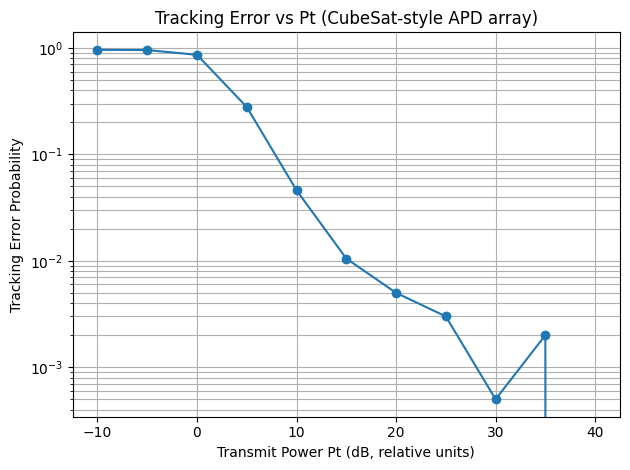

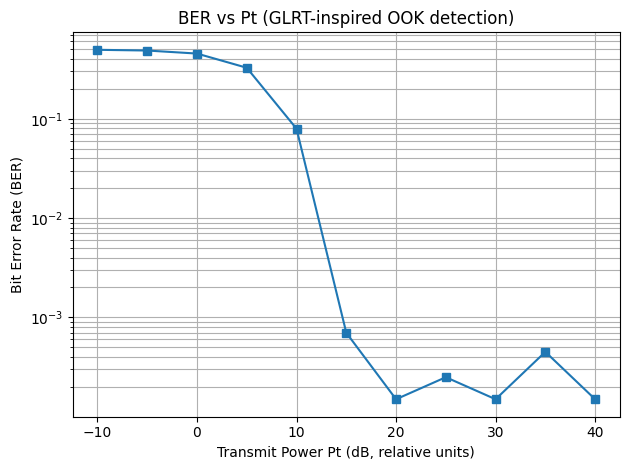

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ---------- Helper: Q-function ----------
def Q(x):
    """Gaussian Q-function."""
    return 0.5 * erfc(x / np.sqrt(2.0))

# ---------- 1. Compute h2_ij for given AoA ----------
def compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    """
    Compute h2_ij (fraction of power on each APD)
    using the Q-function expression from the CubeSat paper.

    Parameters
    ----------
    theta_x, theta_y : float
        AoA deviations (radians) in x-z and y-z planes.
    Na : int
        Number of APDs per dimension (Na x Na array).
    wa : float
        Active width of each APD (meters).
    wf : float
        Dead space between APDs (meters).
    fc : float
        Focal length (meters).
    sigma_I : float
        Std dev of beam intensity at detector plane (meters).

    Returns
    -------
    h2 : ndarray of shape (Na, Na)
        Channel coefficient from lens to each APD (normalized).
    """
    w_prime = wa + wf
    h2 = np.zeros((Na, Na))

    # Beam center at detector plane
    x0 = fc * theta_x
    y0 = fc * theta_y

    for i in range(Na):
        # x boundaries for pixel i
        x_left  = (i - 1 - Na/2) * w_prime + wf/2
        x_right = (i     - Na/2) * w_prime - wf/2

        # Q-arguments in x
        ax1 = (x_left  - x0) / sigma_I
        ax2 = (x_right - x0) / sigma_I

        px = Q(ax1) - Q(ax2)

        for j in range(Na):
            # y boundaries for pixel j
            y_bottom = (j - 1 - Na/2) * w_prime + wf/2
            y_top    = (j     - Na/2) * w_prime - wf/2

            ay1 = (y_bottom - y0) / sigma_I
            ay2 = (y_top    - y0) / sigma_I

            py = Q(ay1) - Q(ay2)

            h2[i, j] = px * py

    # Optional: normalize so total power = 1
    h2_sum = np.sum(h2)
    if h2_sum > 0:
        h2 /= h2_sum

    return h2

# ---------- 2. Generate block of received samples ---------
def generate_block(Pt, Na, L, h, mu, sigma_s, sigma0, p1=0.5, rng=None):
    """
    Generate one OOK block: s[k], and received samples r_ij[k].

    Parameters
    ----------
    Pt : float
        Transmit power scale (we can fold Pt into mu if we like).
    Na : int
        Array dimension.
    L : int
        Block length (number of bits).
    h : ndarray (Na, Na)
        Per-pixel channel coefficient.
    mu, sigma_s, sigma0 : floats
        Photocurrent scaling and noise parameters.
    bit_prob : float
        Probability of bit 1.
    rng : np.random.Generator
        Random number generator.

    Returns
    -------
    s : ndarray (L,)
        Transmitted bits (0/1).
    R : ndarray (Na, Na, L)
        Received samples r_ij[k].
    """
    if rng is None:
        rng = np.random.default_rng()

    # bits: shape (L,)
    s = (rng.random(L) < p1).astype(float)

    # reshape for broadcasting
    h_ij = h[:, :, None]                     # (Na, Na, 1)
    s_k  = s[None, None, :]                 # (1, 1, L)

    mean = mu * h_ij * s_k * Pt             # (Na, Na, L)
    var  = sigma_s**2 * h_ij * s_k + sigma0**2
    std  = np.sqrt(var)

    R = rng.normal(mean, std)               # same shape

    return s, R


# ---------- 3. Simple data detection ----------
def detect_bits_threshold(R):
    """
    Simple OOK detection using a threshold on total intensity y[k].
    R shape: (Na, Na, L)

    Returns
    -------
    s_hat : ndarray (L,)
    """
    Na, _, L = R.shape
    # Sum over all pixels per time k
    y = np.sum(R, axis=(0, 1))

    # Simple threshold: half of max value
    thr = 0.5 * np.max(y)

    s_hat = (y > thr).astype(float)
    return s_hat

# ---------- 4. GLRT-style channel / tracking estimation ----------
def estimate_channel_and_track(R, s_hat, mu):
    """
    Use GLRT-style statistic r''_ij to estimate channel and beam center.

    R shape: (Na, Na, L)
    s_hat : (L,)
    mu : float

    Returns
    -------
    h_hat : (Na, Na)
    i_hat, j_hat : ints
        Estimated beam-center indices.
    """
    Na, _, L = R.shape
    m_hat = int(np.sum(s_hat))

    if m_hat == 0:
        # Cannot estimate channel if no ones detected
        return None, None, None

    # r''_ij = (1/m) sum_k r_ij[k] * s_hat[k]
    R_weighted = R * s_hat[np.newaxis, np.newaxis, :]
    r_pp = np.sum(R_weighted, axis=2) / m_hat

    h_hat = r_pp / mu

    # Beam-center index: argmax |h_hat|^2
    power = np.abs(h_hat)**2
    idx = np.argmax(power)
    i_hat, j_hat = np.unravel_index(idx, (Na, Na))

    return h_hat, i_hat, j_hat

# ---------- 5. One Monte Carlo trial ----------
def one_trial(Pt, params, rng=None):
    """
    Run one block (one realization of jitter, bits, noise).

    Returns
    -------
    ber_block : float
    track_error_block : int (0 or 1)
    """
    if rng is None:
        rng = np.random.default_rng()

    Na      = params["Na"]
    L       = params["L"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    # 1) Sample jitter
    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)

    # 2) Compute h2_ij and use as h_ij
    h2 = compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I)
    h = h2  # here we assume h1 = 1

    # 3) Generate block
    s, R = generate_block(Pt, Na, L, h, mu, sigma_s, sigma0, rng=rng)

    # 4) Data detection
    s_hat = detect_bits_threshold(R)

    # 5) BER for this block
    bit_errors = np.sum(s != s_hat)
    ber_block = bit_errors / L

    # 6) Tracking
    h_hat, i_hat, j_hat = estimate_channel_and_track(R, s_hat, mu)

    # True beam-center index from actual h_ij
    if h_hat is None:
        # Could not estimate (all-zero detected)
        track_error_block = 1
    else:
        power_true = np.abs(h)**2
        idx_true = np.argmax(power_true)
        i_true, j_true = np.unravel_index(idx_true, (Na, Na))

        track_error_block = int((i_true != i_hat) or (j_true != j_hat))

    return ber_block, track_error_block

# ---------- 6. Sweep over Pt and plot ----------
def run_sweep():
    rng = np.random.default_rng(1234)

    # Simulation parameters (toy example)
    params = {
        "Na": 6,               # 6x6 APD array
        "L": 10,               # block length (similar to paper's Ls)
        "wa": 250e-6,          # 250 micrometers
        "wf": 5e-6,            # 5 micrometers
        "fc": 0.03,            # 3 cm
        "sigma_I": 100e-6,     # beam spot std at detector plane
        "sigma_x": 5e-3,       # 2 mrad
        "sigma_y": 5e-3,       # 2 mrad
        "mu": 1.0,             # scale factor: can fold Pt here
        "sigma_s": 0.1,        # shot-noise scaling (toy)
        "sigma0": 0.5         # background + thermal noise (toy)
    }

    Pt_dB_list = np.linspace(-10, 40, 11)  # -10 dB to 10 dB
    Pt_list = 10**(Pt_dB_list / 10.0)

    ber_list = []
    track_err_list = []

    n_trials = 2000  # increase for smoother curves

    for Pt in Pt_list:
        ber_acc = 0.0
        track_err_acc = 0.0

        for _ in range(n_trials):
            ber_block, track_err_block = one_trial(Pt, params, rng)
            ber_acc += ber_block
            track_err_acc += track_err_block

        ber_list.append(ber_acc / n_trials)
        track_err_list.append(track_err_acc / n_trials)

        print(f"Pt={Pt:.3e} -> BER={ber_list[-1]:.3e}, Pte={track_err_list[-1]:.3e}")

    # ----- Plot tracking error vs Pt -----
    plt.figure()
    plt.semilogy(Pt_dB_list, track_err_list, marker="o")
    plt.xlabel("Transmit Power Pt (dB, relative units)")
    plt.ylabel("Tracking Error Probability")
    plt.grid(True, which="both")
    plt.title("Tracking Error vs Pt (CubeSat-style APD array)")
    plt.tight_layout()

    # ----- Plot BER vs Pt -----
    plt.figure()
    plt.semilogy(Pt_dB_list, ber_list, marker="s")
    plt.xlabel("Transmit Power Pt (dB, relative units)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.grid(True, which="both")
    plt.title("BER vs Pt (GLRT-inspired OOK detection)")
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    run_sweep()


True bits:      [1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1]
Detected bits:  [1 1 1 0 0 1 0 0 0 1 0 1 0 0 0 1 0 0 1 1]
Block BER:      0.0
True center:    (np.int64(3), np.int64(3))
Estimated center: (np.int64(3), np.int64(3))
Tracking error?: 0


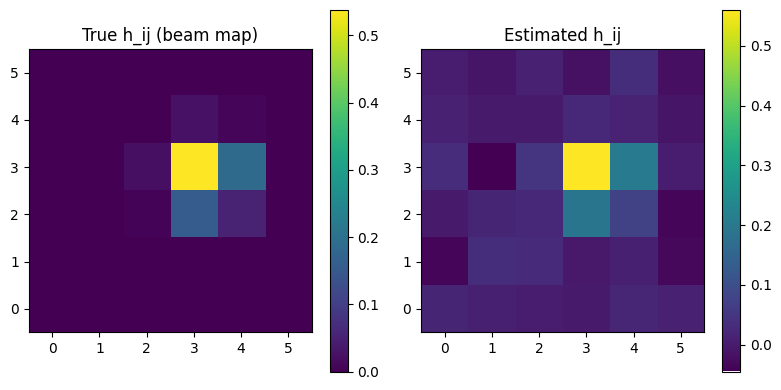

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ---------- Helper: Q-function ----------
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2.0))

# ---------- 1. Compute h2_ij for given AoA (CubeSat-style array) ----------
def compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    """
    CubeSat-like APD array channel h2_ij.
    theta_x, theta_y : beam angles (radians)
    Na    : array size Na x Na
    wa    : active pixel width
    wf    : gap between pixels
    fc    : focal length
    sigma_I : beam spot std at detector plane
    """
    w_prime = wa + wf

    # Beam center at detector plane
    x0 = fc * theta_x
    y0 = fc * theta_y

    # i,j index vectors
    i = np.arange(Na)
    j = np.arange(Na)

    # Pixel boundaries in x
    x_left  = (i - 1 - Na/2) * w_prime + wf/2
    x_right = (i     - Na/2) * w_prime - wf/2

    ax1 = (x_left  - x0) / sigma_I
    ax2 = (x_right - x0) / sigma_I
    px = Q(ax1) - Q(ax2)          # shape (Na,)

    # Pixel boundaries in y
    y_bottom = (j - 1 - Na/2) * w_prime + wf/2
    y_top    = (j     - Na/2) * w_prime - wf/2

    ay1 = (y_bottom - y0) / sigma_I
    ay2 = (y_top    - y0) / sigma_I
    py = Q(ay1) - Q(ay2)          # shape (Na,)

    # Outer product gives full matrix
    h2 = px[:, None] * py[None, :]

    s = np.sum(h2)
    if s > 0:
        h2 /= s
    return h2


# ---------- 2. Generate one block of received samples ----------
def generate_block(Pt, Na, L, h, mu, sigma_s, sigma0, p1=0.5, rng=None):
    """
    Generate one OOK block:
    s[k] ~ Bernoulli(p1)
    r_ij[k] = mu * h_ij * s[k] * Pt + noise
    """
    if rng is None:
        rng = np.random.default_rng()

    s = (rng.random(L) < p1).astype(float)
    R = np.zeros((Na, Na, L))

    for k in range(L):
        sk = s[k]
        for i in range(Na):
            for j in range(Na):
                hij = h[i, j]
                mean = mu * hij * sk * Pt
                var  = sigma_s**2 * hij * sk + sigma0**2
                std  = np.sqrt(var)
                R[i, j, k] = rng.normal(mean, std)
    return s, R

# ---------- 3. JOINT detection + tracking (GLRT-style) ----------
def joint_detect_and_track(R, mu, max_patterns=None):
    """
    Jointly detect bits and estimate channel map using a simplified GLRT approach.

    R : array (Na, Na, L) of received samples
    mu: scale factor

    Steps:
    - Compute y[k] = sum_ij R[i,j,k].
    - Sort k by y[k] descending.
    - For m = 1..L (optionally limited by max_patterns):
        * build candidate s^(m): top-m are 1, others 0
        * estimate h_ij for this s^(m)
        * compute residual error
    - Choose m giving smallest error -> that s_hat, h_hat.
    - Beam center from argmax |h_hat|^2.
    """
    Na, _, L = R.shape

    # 1) Total intensity per time, sort descending
    y = np.sum(R, axis=(0, 1))
    sorted_idx = np.argsort(-y)
    R_sorted = R[:, :, sorted_idx]          # (Na, Na, L)

    if max_patterns is None or max_patterns > L:
        max_patterns = L

    # 2) Prefix sums over time
    cumsum_R  = np.cumsum(R_sorted, axis=2)        # S1_m
    cumsum_R2 = np.cumsum(R_sorted**2, axis=2)     # S2_m

    # Total squared energy (independent of m)
    S2_tot = cumsum_R2[:, :, -1]                   # (Na, Na)
    const_total = np.sum(S2_tot)

    best_metric = -np.inf
    best_m = 1

    # 3) Evaluate metric for each m using prefix sums
    for m in range(1, max_patterns + 1):
        S1_m = cumsum_R[:, :, m-1]                 # sum of first m samples
        # sum_ij S1_m^2 / m
        metric_m = np.sum(S1_m**2) / m

        # minimizing error is same as maximizing this metric
        if metric_m > best_metric:
            best_metric = metric_m
            best_m = m
    # 4) Reconstruct best s_hat using best_m
    s_hat = np.zeros(L, dtype=float)
    s_hat[sorted_idx[:best_m]] = 1.0

    # 5) Re-estimate h_hat using that s_hat (true GLRT-style LS)
    m_hat = best_m
    R_weighted = R * s_hat[None, None, :]
    r_pp = np.sum(R_weighted, axis=2) / m_hat
    h_hat = r_pp / mu

    # 6) Beam center: argmax |h_hat|^2
    power_hat = np.abs(h_hat)**2
    idx_hat = np.argmax(power_hat)
    i_hat, j_hat = np.unravel_index(idx_hat, (Na, Na))

    return s_hat, h_hat, i_hat, j_hat


# ---------- 4. Demo: single block simulation ----------
def demo_single_block():
    rng = np.random.default_rng(123)

    # --- parameters (toy numbers) ---
    Na = 6
    L = 20

    wa = 250e-6    # active pixel width (m)
    wf = 5e-6      # gap (m)
    fc = 0.03      # focal length (m)
    sigma_I = 100e-6

    sigma_x = 6e-3  # 2 mrad jitter
    sigma_y = 6e-3

    mu      = 1.0
    sigma_s = 0.1
    sigma0  = 0.05
    Pt      = 1.0   # relative power

    # --- draw random jitter and compute true channel h_ij ---
    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)
    h_true  = compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I)

    # --- generate one block ---
    s_true, R = generate_block(Pt, Na, L, h_true, mu, sigma_s, sigma0, rng=rng)

    # --- joint detection + tracking ---
    s_hat, h_hat, i_hat, j_hat = joint_detect_and_track(R, mu)

    # --- ground-truth beam-center index from h_true ---
    idx_true = np.argmax(np.abs(h_true)**2)
    i_true, j_true = np.unravel_index(idx_true, (Na, Na))

    # --- metrics ---
    ber_block = np.mean(s_true != s_hat)
    track_err = int((i_hat != i_true) or (j_hat != j_true))

    print("True bits:     ", s_true.astype(int))
    print("Detected bits: ", s_hat.astype(int))
    print("Block BER:     ", ber_block)
    print("True center:   ", (i_true, j_true))
    print("Estimated center:", (i_hat, j_hat))
    print("Tracking error?:", track_err)

    # --- visualize true vs estimated beam map ---
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    im0 = axs[0].imshow(h_true, origin="lower")
    axs[0].set_title("True h_ij (beam map)")
    plt.colorbar(im0, ax=axs[0])

    im1 = axs[1].imshow(h_hat, origin="lower")
    axs[1].set_title("Estimated h_ij")
    plt.colorbar(im1, ax=axs[1])

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    demo_single_block()


Pt(dB)=-10.0 -> BER=4.245e-01, Pte=5.392e-01
Pt(dB)= -4.0 -> BER=2.031e-01, Pte=1.120e-01
Pt(dB)=  2.0 -> BER=6.600e-04, Pte=2.630e-02
Pt(dB)=  8.0 -> BER=5.000e-05, Pte=5.100e-03
Pt(dB)= 14.0 -> BER=5.000e-05, Pte=1.500e-03
Pt(dB)= 20.0 -> BER=5.000e-05, Pte=6.000e-04
Pt(dB)= 26.0 -> BER=0.000e+00, Pte=2.000e-04
Pt(dB)= 32.0 -> BER=1.500e-04, Pte=3.000e-04
Pt(dB)= 38.0 -> BER=5.000e-05, Pte=1.000e-04
Pt(dB)= 44.0 -> BER=3.000e-04, Pte=6.000e-04
Pt(dB)= 50.0 -> BER=5.000e-05, Pte=1.000e-04


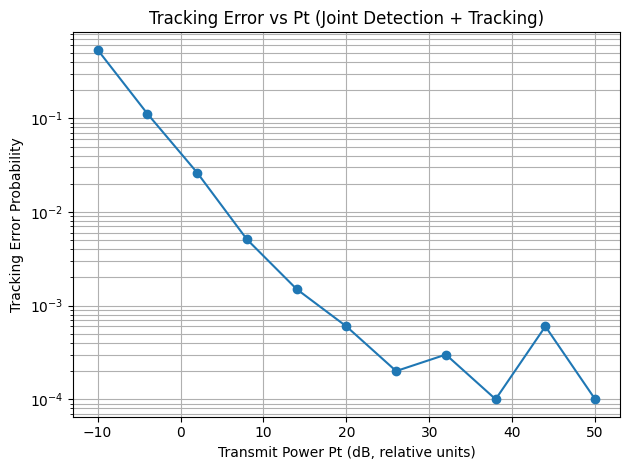

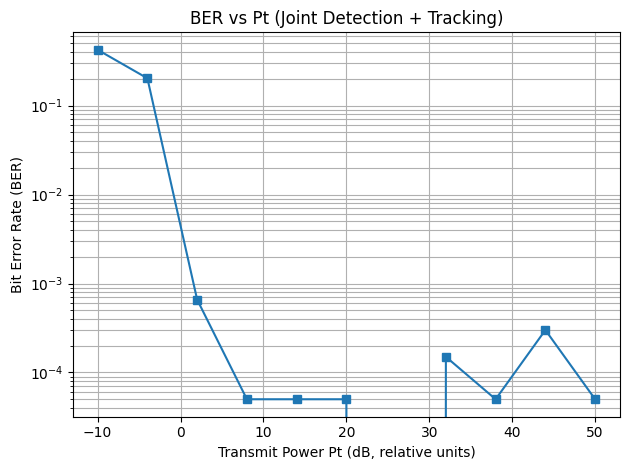

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ======================
# Helper: Q-function
# ======================
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2.0))

# ======================
# 1. CubeSat-style channel: h2_ij
# ======================
def compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    """
    Compute h2_ij (fraction of power on each APD)
    using a Q-function approximation of the Gaussian beam
    over a square APD array.

    theta_x, theta_y : beam angles (radians)
    Na    : array size Na x Na
    wa    : active pixel width (m)
    wf    : gap between pixels (m)
    fc    : focal length (m)
    sigma_I : beam spot std at detector plane (m)
    """
    w_prime = wa + wf

    # Beam center at detector plane
    x0 = fc * theta_x
    y0 = fc * theta_y

    # i,j index vectors
    i = np.arange(Na)
    j = np.arange(Na)

    # Pixel boundaries in x
    x_left  = (i - 1 - Na/2) * w_prime + wf/2
    x_right = (i     - Na/2) * w_prime - wf/2

    ax1 = (x_left  - x0) / sigma_I
    ax2 = (x_right - x0) / sigma_I
    px = Q(ax1) - Q(ax2)          # shape (Na,)

    # Pixel boundaries in y
    y_bottom = (j - 1 - Na/2) * w_prime + wf/2
    y_top    = (j     - Na/2) * w_prime - wf/2

    ay1 = (y_bottom - y0) / sigma_I
    ay2 = (y_top    - y0) / sigma_I
    py = Q(ay1) - Q(ay2)          # shape (Na,)

    # Outer product gives full matrix
    h2 = px[:, None] * py[None, :]

    s = np.sum(h2)
    if s > 0:
        h2 /= s
    return h2


# ======================
# 2. Generate one block of received samples
# ======================
def generate_block(Pt, Na, L, h, mu, sigma_s, sigma0, p1=0.5, rng=None):
    """
    Generate one OOK block:
    s[k] ~ Bernoulli(p1)
    r_ij[k] = mu * h_ij * s[k] * Pt + noise
    with noise variance sigma_s^2 * h_ij * s[k] + sigma0^2.
    """
    if rng is None:
        rng = np.random.default_rng()

    # Transmitted bits
    s = (rng.random(L) < p1).astype(float)

    # Received samples
    R = np.zeros((Na, Na, L))

    for k in range(L):
        sk = s[k]
        for i in range(Na):
            for j in range(Na):
                hij = h[i, j]
                mean = mu * hij * sk * Pt
                var  = sigma_s**2 * hij * sk + sigma0**2
                std  = np.sqrt(var)
                R[i, j, k] = rng.normal(mean, std)

    return s, R

# ======================
# 3. JOINT detection + tracking (GLRT-style)
# ======================
def joint_detect_and_track(R, mu, max_patterns=None):
    """
    Jointly detect bits and estimate channel map using a simplified GLRT:

    - Compute y[k] = sum_ij R[i,j,k].
    - Sort times k by y[k] (largest first).
    - For m = 1..max_patterns:
        * build candidate s^(m): top-m times set to 1, others 0
        * estimate h_ij for that s^(m)
        * compute residual error between model and R
    - Choose m giving smallest error => s_hat, h_hat.
    - Beam center from argmax |h_hat|^2.
    """
    Na, _, L = R.shape

    # 1) Total intensity per time, sort descending
    y = np.sum(R, axis=(0, 1))
    sorted_idx = np.argsort(-y)
    R_sorted = R[:, :, sorted_idx]          # (Na, Na, L)

    if max_patterns is None or max_patterns > L:
        max_patterns = L

    # 2) Prefix sums over time
    cumsum_R  = np.cumsum(R_sorted, axis=2)        # S1_m
    cumsum_R2 = np.cumsum(R_sorted**2, axis=2)     # S2_m

    # Total squared energy (independent of m)
    S2_tot = cumsum_R2[:, :, -1]                   # (Na, Na)
    const_total = np.sum(S2_tot)

    best_metric = -np.inf
    best_m = 1
    # 3) Evaluate metric for each m using prefix sums
    for m in range(1, max_patterns + 1):
        S1_m = cumsum_R[:, :, m-1]                 # sum of first m samples
        # sum_ij S1_m^2 / m
        metric_m = np.sum(S1_m**2) / m
        # minimizing error is same as maximizing this metric
        if metric_m > best_metric:
            best_metric = metric_m
            best_m = m
    # 4) Reconstruct best s_hat using best_m
    s_hat = np.zeros(L, dtype=float)
    s_hat[sorted_idx[:best_m]] = 1.0

    # 5) Re-estimate h_hat using that s_hat (true GLRT-style LS)
    m_hat = best_m
    R_weighted = R * s_hat[None, None, :]
    r_pp = np.sum(R_weighted, axis=2) / m_hat
    h_hat = r_pp / mu

    # 6) Beam center: argmax |h_hat|^2
    power_hat = np.abs(h_hat)**2
    idx_hat = np.argmax(power_hat)
    i_hat, j_hat = np.unravel_index(idx_hat, (Na, Na))

    return s_hat, h_hat, i_hat, j_hat

# ======================
# 4. One Monte Carlo trial (joint detection + tracking)
# ======================
def one_trial_joint(Pt, params, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    Na      = params["Na"]
    L       = params["L"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    # 1) Random jitter
    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)

    # --- NEW: check if beam misses the array entirely ---
    w_prime = wa + wf
    r_array = (Na * w_prime) / 2.0           # approx. array radius (m)

    x0 = fc * theta_x
    y0 = fc * theta_y
    r_d = np.sqrt(x0**2 + y0**2)            # beam center radius at detector

    if r_d > r_array:
        # FULL MISALIGNMENT CASE:
        # No matter how big Pt is, there is no useful signal.
        # Treat bits as undecodable (BER ~ 0.5) and tracking always wrong.
        ber_block = 0.5
        track_error_block = 1
        return ber_block, track_error_block

    # 2) Channel map h_true (from geometry) when beam is within array
    h_true = compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I)

    # 3) Generate block
    s_true, R = generate_block(Pt, Na, L, h_true, mu, sigma_s, sigma0, rng=rng)

    # 4) Joint detection + tracking
    s_hat, h_hat, i_hat, j_hat = joint_detect_and_track(R, mu)

    # 5) BER for this block
    ber_block = np.mean(s_true != s_hat)

    # 6) True beam-center index from h_true
    power_true = np.abs(h_true)**2
    idx_true = np.argmax(power_true)
    i_true, j_true = np.unravel_index(idx_true, (Na, Na))

    track_error_block = int((i_true != i_hat) or (j_true != j_hat))

    return ber_block, track_error_block

Count=0 # Keep global initialization
# ======================
# 5. Sweep over Pt and plot BER + tracking error
# ======================
def run_sweep_joint():
    rng = np.random.default_rng(1234)

    # --- System / simulation parameters (toy values, adjust as needed) ---
    params = {
        "Na": 6,               # 6x6 APD array
        "L": 20,               # block length (like L in CubeSat paper)
        "wa": 250e-6,          # active pixel width (m)
        "wf": 5e-6,            # gap between pixels (m)
        "fc": 0.03,            # focal length (m)
        "sigma_I": 100e-6,     # beam spot std at detector plane
        "sigma_x": 6e-3,       # 2 mrad jitter
        "sigma_y": 6e-3,       # 2 mrad jitter
        "mu": 1.0,             # photocurrent scaling
        "sigma_s": 0.1,        # shot-noise scale
        "sigma0": 0.05         # background + thermal noise
    }

    # Transmit powers (in dB, arbitrary scale)
    Pt_dB_list = np.linspace(-10, 50, 11)  # -10, -8, ..., 10 dB
    Pt_list = 10**(Pt_dB_list / 10.0)

    ber_list = []
    track_err_list = []

    n_trials = 10**4
    for Pt, Pt_dB in zip(Pt_list, Pt_dB_list):
        ber_acc = 0.0
        track_err_acc = 0.0

        for _ in range(n_trials):
            ber_block, track_err_block = one_trial_joint(Pt, params, rng)
            ber_acc += ber_block
            track_err_acc += track_err_block

        ber_mean = ber_acc / n_trials
        pte_mean = track_err_acc / n_trials

        ber_list.append(ber_mean)
        track_err_list.append(pte_mean)

        print(f"Pt(dB)={Pt_dB:5.1f} -> BER={ber_mean:.3e}, Pte={pte_mean:.3e}")

    # ----- Plot tracking error vs Pt -----
    plt.figure()
    plt.semilogy(Pt_dB_list, track_err_list, marker="o")
    plt.xlabel("Transmit Power Pt (dB, relative units)")
    plt.ylabel("Tracking Error Probability")
    plt.grid(True, which="both")
    plt.title("Tracking Error vs Pt (Joint Detection + Tracking)")
    plt.tight_layout()

    # ----- Plot BER vs Pt -----
    plt.figure()
    plt.semilogy(Pt_dB_list, ber_list, marker="s")
    plt.xlabel("Transmit Power Pt (dB, relative units)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.grid(True, which="both")
    plt.title("BER vs Pt (Joint Detection + Tracking)")
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    run_sweep_joint()

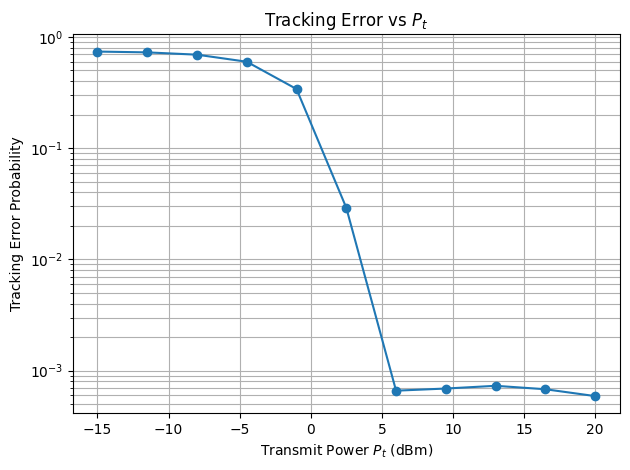

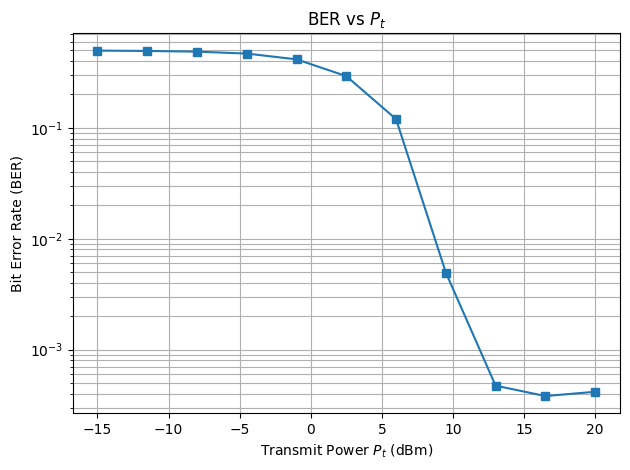

In [21]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc

# ======================
# Helper: Q-function
# ======================
def Q(x):
    return 0.5 * erfc(x / np.sqrt(2.0))

# ======================
# 1. CubeSat-style channel: h2_ij
# ======================
def compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I):
    w_prime = wa + wf

    x0 = fc * theta_x
    y0 = fc * theta_y

    i = np.arange(Na)
    j = np.arange(Na)

    x_left  = (i - 1 - Na/2) * w_prime + wf/2
    x_right = (i     - Na/2) * w_prime - wf/2

    ax1 = (x_left  - x0) / sigma_I
    ax2 = (x_right - x0) / sigma_I
    px = Q(ax1) - Q(ax2)

    y_bottom = (j - 1 - Na/2) * w_prime + wf/2
    y_top    = (j     - Na/2) * w_prime - wf/2

    ay1 = (y_bottom - y0) / sigma_I
    ay2 = (y_top    - y0) / sigma_I
    py = Q(ay1) - Q(ay2)

    h2 = px[:, None] * py[None, :]
    s = np.sum(h2)
    if s > 0:
        h2 /= s
    return h2

# ======================
# 2. Generate one block of received samples
# ======================
def generate_block(Pt, Na, L, h, mu, sigma_s, sigma0, p1=0.5, rng=None):
    if rng is None:
        rng = np.random.default_rng()

    s = (rng.random(L) < p1).astype(float)
    R = np.zeros((Na, Na, L))

    for k in range(L):
        sk = s[k]
        for i in range(Na):
            for j in range(Na):
                hij = h[i, j]
                mean = mu * hij * sk * Pt
                var  = sigma_s**2 * hij * sk *Pt + sigma0**2
                R[i, j, k] = rng.normal(mean, np.sqrt(var))

    return s, R

# ======================
# 3. JOINT detection + tracking
# ======================
def joint_detect_and_track(R, mu, max_patterns=None):
    Na, _, L = R.shape

    y = np.sum(R, axis=(0, 1))
    sorted_idx = np.argsort(-y)
    R_sorted = R[:, :, sorted_idx]

    if max_patterns is None or max_patterns > L:
        max_patterns = L

    cumsum_R = np.cumsum(R_sorted, axis=2)

    best_metric = -np.inf
    best_m = 1

    for m in range(1, max_patterns + 1):
        S1_m = cumsum_R[:, :, m-1]
        metric_m = np.sum(S1_m**2) / m
        if metric_m > best_metric:
            best_metric = metric_m
            best_m = m

    s_hat = np.zeros(L)
    s_hat[sorted_idx[:best_m]] = 1.0

    R_weighted = R * s_hat[None, None, :]
    h_hat = np.sum(R_weighted, axis=2) / (best_m * mu)

    power_hat = np.abs(h_hat)**2
    idx_hat = np.argmax(power_hat)
    i_hat, j_hat = np.unravel_index(idx_hat, (Na, Na))

    return s_hat, h_hat, i_hat, j_hat

# ======================
# 4. One Monte Carlo trial
# ======================
def one_trial_joint(Pt, params, rng):
    Na      = params["Na"]
    L       = params["L"]
    wa      = params["wa"]
    wf      = params["wf"]
    fc      = params["fc"]
    sigma_I = params["sigma_I"]
    sigma_x = params["sigma_x"]
    sigma_y = params["sigma_y"]
    mu      = params["mu"]
    sigma_s = params["sigma_s"]
    sigma0  = params["sigma0"]

    theta_x = rng.normal(0.0, sigma_x)
    theta_y = rng.normal(0.0, sigma_y)

    w_prime = wa + wf
    r_array = (Na * w_prime) / 2.0

    x0 = fc * theta_x
    y0 = fc * theta_y
    r_d = np.sqrt(x0**2 + y0**2)

    if r_d > r_array:
        return 0.5, 1

    h_true = compute_h2_matrix(theta_x, theta_y, Na, wa, wf, fc, sigma_I)
    s_true, R = generate_block(Pt, Na, L, h_true, mu, sigma_s, sigma0, rng=rng)
    s_hat, h_hat, i_hat, j_hat = joint_detect_and_track(R, mu)

    ber = np.mean(s_true != s_hat)

    idx_true = np.argmax(np.abs(h_true)**2)
    i_true, j_true = np.unravel_index(idx_true, (Na, Na))

    track_error = int((i_true != i_hat) or (j_true != j_hat))

    return ber, track_error

# ======================
# 5. Sweep over Pt (OPTION A: relabel to dBm)
# ======================
def run_sweep_joint():
    rng = np.random.default_rng(1234)

    params = {
        "Na": 2,
        "L": 20,
        "wa": 2e-3,
        "wf": 0,
        "fc": 0.05,
        "sigma_I": 100e-6,
        "sigma_x": 5e-3,
        "sigma_y": 5e-3,
        "mu": 1.0,
        "sigma_s": 0.01,
        "sigma0": 0.001
    }

    Pt_dB_list = np.linspace(-45, -10, 11)        # internally dBW
    Pt_list = 10**(Pt_dB_list / 10.0)            # watts
    Pt_dBm_list = Pt_dB_list + 30                # relabel for plots

    ber_list = []
    track_err_list = []

    n_trials = 10**5
    for Pt in Pt_list:
        ber_acc = 0.0
        track_err_acc = 0.0

        for _ in range(n_trials):
            ber, te = one_trial_joint(Pt, params, rng)
            ber_acc += ber
            track_err_acc += te

        ber_list.append(ber_acc / n_trials)
        track_err_list.append(track_err_acc / n_trials)

    # ---- Tracking Error ----
    plt.figure()
    plt.semilogy(Pt_dBm_list, track_err_list, marker="o")
    plt.xlabel("Transmit Power $P_t$ (dBm)")
    plt.ylabel("Tracking Error Probability")
    plt.grid(True, which="both")
    plt.title("Tracking Error vs $P_t$")
    plt.tight_layout()

    # ---- BER ----
    plt.figure()
    plt.semilogy(Pt_dBm_list, ber_list, marker="s")
    plt.xlabel("Transmit Power $P_t$ (dBm)")
    plt.ylabel("Bit Error Rate (BER)")
    plt.grid(True, which="both")
    plt.title("BER vs $P_t$")
    plt.tight_layout()

    plt.show()

if __name__ == "__main__":
    run_sweep_joint()
